#  Abstractive Summarization of Podcast Transcripts with BART using Semantic Self-segmentation
Podcasts are a rapidly growing medium for news, commentary, entertainment, and learning.  Some podcast shows release new episodes on a regular schedule (daily, weekly, etc); others irregularly.  Some podcast shows feature short episodes of 5 minutes or less touching on one or two topics; others may release 3+ hour long episodes touching on a wide range of topics.  Some are structured as news delivery, some as conversations, some as storytelling.

**Goal**: given a podcast episode, its audio, and transcription, return a short text snippet capturing the most important information in the content. Returned summaries should be grammatical, standalone statement of significantly shorter length than the input episode description.

The task is to provide a short text summary that the user might read when deciding whether to listen to a podcast. Thus the summary should accurately convey the content of the podcast, and be short enough to quickly read on a smartphone screen. It should also be human-readable.

For further information about the challenge, take a look to Podcasts Track Guidelines:
- [TREC 2020 Podcasts Track](https://trecpodcasts.github.io/participant-instructions-2020.html)

In [1]:
import numpy as np
import os
import pandas as pd
import regex as re
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from difflib import SequenceMatcher
from collections import Counter
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import pysbd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AdamWeightDecay
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers.keras_callbacks import KerasMetricCallback
import evaluate
import bert_score

from transcript_utils import get_transcription, semantic_segmentation, extract_features

# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\peppe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# login to the huggingface hub, necessary only to push the fine-tuned model to the hub
from huggingface_hub import notebook_login
notebook_login()
!git lfs install

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## 1. Dataset preparation

### 1.1 Dataset reading

In [2]:
dataset_path = os.path.join(os.path.abspath(""), 'podcasts-no-audio-13GB')

metadata_path_train = os.path.join(dataset_path, 'metadata.tsv')
metadata_train = pd.read_csv(metadata_path_train, sep='\t')
print("Columns: ", metadata_train.columns)
print("Shape: ", metadata_train.shape)

Columns:  Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix'],
      dtype='object')
Shape:  (105360, 12)


### 1.2 Dataset analysis

Statistics about episode duration:
count    105360.000000
mean         33.845715
std          22.735674
min           0.175317
25%          13.552638
50%          31.643375
75%          50.446825
max         304.953900
Name: duration, dtype: float64


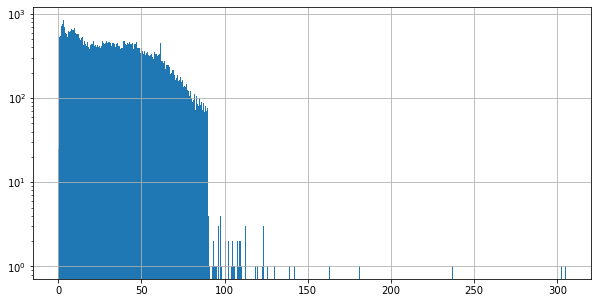

In [6]:
print("Statistics about episode duration:\n"
      f"{metadata_train['duration'].describe()}")
metadata_train['duration'].hist(bins=1000, figsize=(10,5), log=True)
plt.show()

Statistics about number of episodes per show:
count    18376.000000
mean         5.733566
std         19.310585
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1072.000000
dtype: float64


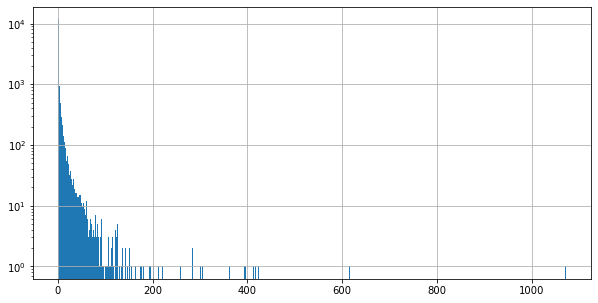

In [5]:
show_episodes = metadata_train.groupby(['show_filename_prefix']).apply(lambda x: list(zip(x['episode_filename_prefix'], x['episode_description']))).to_dict()
show_n_episodes = {k: len(v) for k, v in show_episodes.items()}
print("Statistics about number of episodes per show:\n"
      f"{pd.Series(show_n_episodes.values()).describe()}")
pd.Series(show_n_episodes.values()).hist(bins=1000, figsize=(10,5), log=True)
plt.show()

### 1.3 Episode description cleaning

First of all, some of the episodes contain a `NaN` value in the `episode_description` and `show_description` columns. Let's remove them.

In [90]:
print("Before dropping NaN values: \n", metadata_train.isna().any())
metadata_train.dropna(subset=['episode_description', 'show_description'], inplace=True)
print("\nAfter dropping NaN values:\n", metadata_train.isna().any())

Before dropping NaN values: 
 show_uri                   False
show_name                  False
show_description            True
publisher                  False
language                   False
rss_link                   False
episode_uri                False
episode_name               False
episode_description         True
duration                   False
show_filename_prefix       False
episode_filename_prefix    False
dtype: bool

After dropping NaN values:
 show_uri                   False
show_name                  False
show_description           False
publisher                  False
language                   False
rss_link                   False
episode_uri                False
episode_name               False
episode_description        False
duration                   False
show_filename_prefix       False
episode_filename_prefix    False
dtype: bool


It is also available a *gold dataset* of 150 episodes composed by 6 set of summaries for each episode (900 document-summary-grade triplets) that were graded on the Bad/Fair/Good/Excellent scale (0-3).
Before starting the cleaning process, we merged this gold dataset with the dataset we are going to clean, and the best summary of each episode will be considered.

In [91]:
metadata_path_gold = os.path.join(dataset_path, '150gold.tsv')
metadata_gold = pd.read_csv(metadata_path_gold, sep='\t')

quality = {
    'B': 1,
    'F': 2,
    'G': 3,
    'E': 4
}

# convert egfb columns to a quality score
egfb_columns = ['EGFB', 'EGFB.1', 'EGFB.2', 'EGFB.3', 'EGFB.4', 'EGFB.5']
egfb_to_quality = metadata_gold[egfb_columns].applymap(lambda x: quality[x])

# remove rows with no quality > 1
egfb_to_quality = egfb_to_quality[[any(row > 1) for row in egfb_to_quality.values]] 

# select the best transcript for each episode
best_egfb = egfb_to_quality.apply(lambda x: x.idxmax(), axis=1)
best_summary = [metadata_gold.iloc[i, np.argwhere(metadata_gold.columns == egfb)[0][0] - 1] for i, egfb in best_egfb.iteritems()]

metadata_gold = metadata_gold.loc[best_egfb.index]
metadata_gold['best_summary'] = best_summary

# create a dictionary of the best summary for each episode
gold_summaries = {row['episode id']: row['best_summary'] for i, row in metadata_gold.iterrows()}


In [92]:
# substitute the episode descriptions correspondent to the episodes in the gold set with the best summary
for i, row in metadata_train.iterrows():
    if row['episode_uri'] in gold_summaries.keys():
        metadata_train.at[i, 'episode_description'] = gold_summaries[row['episode_uri']]

We strive to enhance the quality of creator descriptions using heuristics. In order to do that, the following cleaning steps are preformed:
- removing the content after "---" that usually is a sponsorship or a boilerplate (e.g., *“--- This episode is sponsored by ...”* *“--- Send in a voice message”*)
- remove sentences that contain URLs, @mentions and email addresses in the episode descriptions
- remove tokens corresponding to emojii
- identify sentences that contain not useful content and remove them from the descriptions. In order to do that, we compute a *salience score* for each sentence of the description by summing over word IDF scores. Then we remove sentences if their salience scores are lower than a threshold. 


In [10]:
def compute_document_frequencies(descriptions):
    """
    Compute the document frequencies in the whole dataset descriptions

    Parameters
    ----------
    descriptions : list of str
        The descriptions of the episodes
    
    Returns
    -------
    A dictionary of word frequencies
    """
    seg = pysbd.Segmenter(language="en", clean=False)

    # get a set of words contained in each description (words are all lowercase)
    flattened_descriptions = []
    for description in tqdm(descriptions, desc="Computing word frequencies"):
        description_set = set()
        for sentence in seg.segment(description):
            description_set.update([word.lower() for word in word_tokenize(sentence)])
        flattened_descriptions.extend(list(description_set))
            
    counts = pd.Series(Counter(flattened_descriptions))  # Get counts and transform to Series
    return counts

# compute the document frequencies that will be used to compute the sentence salience score
document_frequencies = compute_document_frequencies(metadata_train['episode_description'])

Computing word frequencies: 100%|██████████| 105153/105153 [07:58<00:00, 219.77it/s]


In [93]:
# store the old dataframe to make comparisons
metadata_train_old = metadata_train.copy()

In [94]:
def remove_boilerplate(description):
    """
    Remove boilerplate from the episode description

    Parameters
    ----------
    description : str
        The episode description

    Returns
    -------
    A description without boilerplate (str)
    """
    boilerplate_re = re.compile(r"---.*")
    return boilerplate_re.sub("", description)

def remove_link_or_sponsors(description):
    """
    Remove sentences containing links and sponsors or username and hashtag from the episode description

    Parameters
    ----------
    description : str
        The episode description

    Returns
    -------
    A description without links and sponsors (str)
    """
    username_and_hashtag_re = re.compile(r"(\B@\w+|\B#\w+)")
    links_or_sponsors_re = re.compile(
        r"(http|https|[pP]atreon|[eE]mail|[dD]onate|IG|[iI]nstagram|[fF]acebook|[yY]outube|[tT]witter|[dD]iscord|[fF]ollow|[sS]potify)"
    )

    # remove username and hashtag
    description = username_and_hashtag_re.sub(" ", description)

    # remove sentences containing links and sponsors
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = seg.segment(description)
    sentences = [sentence for sentence in sentences if not links_or_sponsors_re.search(sentence)] 
    return " ".join(sentences)

def remove_emojii(description):
    """
    Remove emojii from the episode description

    Parameters
    ----------
    description : str
        The episode description

    Returns
    -------
    A description without emojii (str)
    """
    emoji_re = re.compile(r"[^\x00-\x7F]+")
    return emoji_re.sub(" ", description)

print("\nRemoving boilerplate from the episode descriptions:")
metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(remove_boilerplate)

print("Removing links and sponsors from the episode descriptions:")
metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(remove_link_or_sponsors)

print("Removing emojii from the episode descriptions:")
metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(remove_emojii)


Removing boilerplate from the episode descriptions:


100%|██████████| 105153/105153 [00:00<00:00, 120642.24it/s]


Removing links and sponsors from the episode descriptions:


100%|██████████| 105153/105153 [06:19<00:00, 276.95it/s]


Removing emojii from the episode descriptions:


100%|██████████| 105153/105153 [00:00<00:00, 124739.31it/s]


In [79]:
# see a few examples of comparisons between the old and new descriptions
samples = [137, 172]
print("\nExamples of comparisons before and after removing sponsors and links:")
for i in samples:
        print("BEFORE:" 
                f"\n\t- {metadata_train_old['episode_description'].iloc[i]}")
        print("AFTER:"
                f"\n\t- {metadata_train['episode_description'].iloc[i]}")
        print("\n")


Examples of comparisons before and after removing sponsors and links:
BEFORE:
	- If you like ASMR you will love this White Noise Machine on Amazon! Tap here to check it out! If you enjoyed this make sure to give us a 5 star rating!  ---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app  Support this podcast: https://anchor.fm/AdamDino/support
AFTER:
	- If you like ASMR you will love this White Noise Machine on Amazon!  Tap here to check it out!  If you enjoyed this make sure to give us a 5 star rating!  


BEFORE:
	- Danielle and Jessi could talk your ears off when it comes to this topic. Episode 004 is all about their skincare routines, products they love, and tips and tricks for feeling radiant and confident in your own skin. Follow them @basicallyorganicpodcast (and @jessimechler @itsdaniellebridges) for tags of all the brands they’re currently loving! Rate and subscribe!!   ---   Support this podcast: https://anchor.fm/basicallyorg

In [95]:
def sentence_salience_score(sentence, num_descriptions, document_frequencies):
    """
    Compute the salience score of a sentence by summing over word IDF scores.
    Only alphabetic words that are longer that one character and are neither stop words nor words like 'episode' or 'podcast'
    are considered when computing sentence salience scores.

    Parameters
    ----------
    sentence : str
        The sentence to compute the salience score for
    num_descriptions : int
        The number of descriptions in the dataset
    document_frequencies : pandas.Series
        The document frequencies in the whole dataset descriptions
    
    Returns
    -------
    The salience score of the sentence (float)
    """
    idf_scores = []
    tokenized_sentence = word_tokenize(sentence)

    # compute IDF scores for each word in the sentence and sum them up 
    
    for word in tokenized_sentence:
        lower_world = word.lower()
        # consider only alphabetic words, and remove stop words, single character
        if lower_world in document_frequencies.keys() and lower_world.isalpha() and lower_world not in stopwords.words('english') and len(lower_world) > 1 and lower_world not in ['episode', 'podcast']:
            # get document frequency
            df = document_frequencies[lower_world]

            # compute idf score
            idf_score = np.log(num_descriptions/df)
            idf_scores.append(idf_score)

    idf_scores = np.array(idf_scores) 
    salience_score = idf_scores.mean() if len(idf_scores)>0 else 0.0
    return salience_score

def remove_unuseful_sentences(description, num_descriptions, word_frequencies, threshold=3.6):
    """
    Remove sentences that are not useful for the transcriptions

    Parameters
    ----------
    description : str
        The episode description
    num_descriptions : int
        The number of descriptions in the dataset
    word_frequencies : pandas.Series
        The word frequencies in the whole dataset descriptions
    threshold : double
        The threshold for the salience score of a sentence to be considered useful

    Returns
    -------
    A description without unuseful sentences (str)
    """
    # segment the text into sentences
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = seg.segment(description)
    # remove sentences that are not useful for the transcriptions
    sentences = [sentence for sentence in sentences if sentence_salience_score(sentence, num_descriptions, word_frequencies) > threshold]
    return " ".join(sentences)

metadata_train['episode_description'] = metadata_train['episode_description'].progress_map(lambda x: remove_unuseful_sentences(x, metadata_train.shape[0], document_frequencies))

100%|██████████| 105153/105153 [24:23<00:00, 71.84it/s] 


In [96]:
# see a few examples of comparisons between the old and new descriptions
samples = [137, 172]
print("\nExamples of comparisons before and after removing unuseful sentences:")
for i in samples:
        print("BEFORE:" 
                f"\n\t- {metadata_train_old['episode_description'].iloc[i]}")
        print("AFTER:"
                f"\n\t- {metadata_train['episode_description'].iloc[i]}")
        print("\n")


Examples of comparisons before and after removing sponsors and links:
BEFORE:
	- If you like ASMR you will love this White Noise Machine on Amazon! Tap here to check it out! If you enjoyed this make sure to give us a 5 star rating!  ---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app  Support this podcast: https://anchor.fm/AdamDino/support
AFTER:
	- If you like ASMR you will love this White Noise Machine on Amazon!   Tap here to check it out!  


BEFORE:
	- Danielle and Jessi could talk your ears off when it comes to this topic. Episode 004 is all about their skincare routines, products they love, and tips and tricks for feeling radiant and confident in your own skin. Follow them @basicallyorganicpodcast (and @jessimechler @itsdaniellebridges) for tags of all the brands they’re currently loving! Rate and subscribe!!   ---   Support this podcast: https://anchor.fm/basicallyorganicpodcast/support
AFTER:
	- Danielle and Jessi could tal

### 1.4 Episode selection
In order to select a subset of the training set that is proper to achieve good summarization results, we filtered out some descriptions using three heuristics shown in the table below. These filters overlap to some extent, and remove about a third of the entire set. The remaining episodes we call the **Brass Set**.

| Criterion                        | Threshold                                                    |
| -------------------------------- | ------------------------------------------------------------ |
| Length                           | descriptions that are very long (> 750 characters) or short (< 20 characters). |
| Similarity to show description   | descriptions with high lexical overlap (over 50%) with their show description. |
| Similarity to other descriptions | descriptions with high lexical overlap (over 60%) with other episode descriptions in the same show. |


In [112]:
def check_lenght_brass(episode, upper_bound=750, lower_bound=20):
    """
    Check if the episode descriptions is not too long (> 750 characters) or not too short (< 20 characters)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    upper_bound : int
        The upper bound of the episode description length
    lower_bound : int
        The lower bound of the episode description length
    
    Returns
    -------
    Boolean indicating if the episode description is long enough
    """
    return len(episode['episode_description']) <= upper_bound and len(episode['episode_description']) >= lower_bound
    
def description_similarity(a, b):
    """
    Measure the overlapping between two descriptions

    Parameters
    ----------
    a : str
        The first description
    b : str
        The second description
    
    Returns
    -------
    Value indicating the overlapping between the two descriptions
    """
    return SequenceMatcher(None, a, b).ratio()

def check_show_description_overlap_brass(episode, thresh=0.5):
    """
    Check if the episode descriptions overlapping with the show description is not too high (< 0.5)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    thresh : float
        The threshold of the overlap between the episode description and the show description

    Returns
    -------
    Boolean indicating if the episode description is different enough from the show description
    """
    return description_similarity(episode['show_description'], episode['episode_description']) < thresh
    
def check_other_description_overlap_brass(episode, show_episodes, thresh=0.6):
    """
    Check if the episode descriptions overlapping with the other description in the same show is not too high (< 0.6)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    show_episodes : dict
        A dictionary of the episodes of the same show
    thresh : float
        The threshold of the overlap between the episode description and the other description
    
    Returns
    -------
    Boolean indicating if the episode description is different enough from the other description
    """
    for other_prefix, other_description in show_episodes[episode['show_filename_prefix']]:
        if other_prefix != episode['episode_filename_prefix'] and description_similarity(episode['episode_description'], other_description) > thresh and len(episode['episode_description']) < len(other_description):
            return False
    return True


brass_set_lenght = metadata_train[metadata_train.progress_apply(check_lenght_brass, axis=1)]
print(f"Removed {len(metadata_train) - len(brass_set_lenght)} episodes ({(100-(len(brass_set_lenght)/len(metadata_train)*100)):.2f}%) because of too long or too short descriptions")

brass_set_show_overlap = brass_set_lenght[brass_set_lenght.progress_apply(check_show_description_overlap_brass, axis=1)]
print(f"Removed {len(brass_set_lenght) - len(brass_set_show_overlap)} episodes ({(100-(len(brass_set_show_overlap)/len(brass_set_lenght)*100)):.2f}%) because of too high overlap with the show description")

show_episodes = brass_set_show_overlap.groupby(['show_filename_prefix']).apply(lambda x: list(zip(x['episode_filename_prefix'], x['episode_description']))).to_dict()
brass_set = brass_set_show_overlap[brass_set_show_overlap.progress_apply(lambda x: check_other_description_overlap_brass(x, show_episodes), axis=1)]
print(f"Removed {len(brass_set_show_overlap) - len(brass_set)} episodes ({(100-(len(brass_set)/len(brass_set_show_overlap)*100)):.2f}%) because of too high overlap with other descriptions in the same show")

100%|██████████| 105153/105153 [00:01<00:00, 77508.03it/s]


Removed 17108 episodes (16.27%) because of too long or too short descriptions


100%|██████████| 88045/88045 [01:16<00:00, 1157.95it/s]


Removed 1597 episodes (1.81%) because of too high overlap with the show description


100%|██████████| 86448/86448 [41:22<00:00, 34.82it/s]  

Removed 9033 episodes (10.45%) because of too high overlap with other descriptions in the same show


In [128]:
# look to the removed episode descriptions due to the overlap with the show description
removed_episodes_show_overlap = pd.concat([brass_set_lenght, brass_set_show_overlap]).drop_duplicates(keep=False)[['show_description', 'episode_description']]
removed_episodes_show_overlap['overlapping'] = removed_episodes_show_overlap.apply(lambda row: description_similarity(row['show_description'], row['episode_description']), axis=1)

num_to_visualize = 3

for _ in range(num_to_visualize):
    row = removed_episodes_show_overlap.sample()
    print(f"Episode description: \n\t{row['episode_description'].values[0]}")
    print(f"Show description: \n\t{row['show_description'].values[0]}")
    print(f"Overlapping score: \n\t{row['overlapping'].values[0]}")
    print("\n")

Episode description: 
	Life and fashion all packed into a panini 
Show description: 
	Life and fashion all packed into a panini
Overlapping score: 
	0.9879518072289156


Episode description: 
	Today, three of the worlds straightest males have gathered to talk about the straightest things. 
Show description: 
	On the Wearings-Socks Podcast, three of the worlds straightest males have gathered to talk about the straightest things.
Overlapping score: 
	0.8663594470046083


Episode description: 
	We look back at the case of the Maryland Court vs Adnan Syed and tell you what we think really happened on that fateful day in 1999 
Show description: 
	We're out here doing a podcast about the Serial Podcast that is based off of the State of Maryland v. Adnan Syed case that happened back in 1999.
Overlapping score: 
	0.51985559566787




In [165]:
# look to the removed episode descriptions due to the overlap with the other episode descriptions in the same show
removed_episodes_other_overlap = pd.concat([brass_set, brass_set_show_overlap]).drop_duplicates(keep=False)[['show_filename_prefix', 'episode_filename_prefix', 'episode_description']]
two_episodes_show  = {str(show_filename_prefix): show_episodes[show_filename_prefix] for show_filename_prefix in removed_episodes_other_overlap['show_filename_prefix'] if len(show_episodes[show_filename_prefix]) == 2 }
removed_episodes_other_overlap = removed_episodes_other_overlap[removed_episodes_other_overlap['show_filename_prefix'].isin(two_episodes_show.keys())]
other_episode_show = {}
for i, row in removed_episodes_other_overlap.iterrows():
    if row['show_filename_prefix'] in two_episodes_show:
        if row['episode_filename_prefix'] in two_episodes_show[row['show_filename_prefix']][0]:
            other_episode_show[row['show_filename_prefix']] = two_episodes_show[row['show_filename_prefix']][1][1]
        else:
            other_episode_show[row['show_filename_prefix']] = two_episodes_show[row['show_filename_prefix']][0][1]
removed_episodes_other_overlap['other_episode_description'] = removed_episodes_other_overlap.apply(lambda row: other_episode_show[row['show_filename_prefix']], axis=1)
removed_episodes_other_overlap['overlapping'] = removed_episodes_other_overlap.apply(lambda row: description_similarity(row['episode_description'], row['other_episode_description']), axis=1)

num_to_visualize = 3

for _ in range(num_to_visualize):
    row = removed_episodes_other_overlap.sample()
    print(f"Episode description: \n\t{row['episode_description'].values[0]}")
    print(f"Other episode description: \n\t{row['other_episode_description'].values[0]}")
    print(f"Overlapping score: \n\t{row['overlapping'].values[0]}")
    print("\n")

Episode description: 
	A real banger, one for the ages  
Other episode description: 
	This is a banger, one for the ages  
Overlapping score: 
	0.8405797101449275


Episode description: 
	In this exercise, drift off to sleep while listening to nature sounds. 
Other episode description: 
	In the full version of this exercise, focus on muscle relaxation while listening to nature sounds. 
Overlapping score: 
	0.7176470588235294


Episode description: 
	In this episode, Shawna and Larry talk with Jason Lobmeyer about helpful tips on how to be a great CCV kids coach. 
Other episode description: 
	In this episode, Shawna and Larry talk with George Mang about helpful tips on how deal with behavioral issues in a kids experience. 
Overlapping score: 
	0.7125506072874493




#### 1.4.1 Further selection of the data
The podcast episodes should be restricted to the English language, but they cover a range of geographical regions and we found a number of non-English podcasts in the dataset. So we remove them.

In [219]:
try:
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('words')
wordset = set(words.words())

def is_english(text, threshold = 0.3):
    """
    Check if the text is written in english

    Parameters
    ----------
    text : str
        The text to check
    threshold : float
        The threshold of the ratio of english words in the text
    
    Returns
    -------
    Boolean indicating if the text is written in english
    """
    tokenized = word_tokenize(text)
    alpha_tokenized = [word.lower() for word in tokenized if word.isalpha()]
    dictionary_score = sum([word.lower() in wordset for word in alpha_tokenized
                           ]) / len(alpha_tokenized)
    return dictionary_score > threshold

# remove episodes with non english description
len_old_brass_set = len(brass_set)
brass_set = brass_set[brass_set.progress_apply(lambda x: is_english(x['episode_description']), axis=1)]
print(f"Removed {len_old_brass_set - len(brass_set)} episodes ({(100-(len(brass_set)/len_old_brass_set*100)):.2f}%) because of non english description")

100%|██████████| 77415/77415 [00:26<00:00, 2925.98it/s]

Removed 374 episodes (0.48%) because of non english description


In [220]:
# store brass set
brass_set.to_csv(os.path.join(os.path.dirname(metadata_path_train), "brass_set.tsv"), index=False, sep='\t')

### 1.5 Transcript filtering
For each episode, extract the chunks from the transcript, classify them to evaluate their salience and take the ones with the highest score up to fulfill 1024 tokens.

In [ ]:
# load brass set
brass_set = pd.read_csv(os.path.join(dataset_path, "brass_set.tsv"), sep='\t')

In [7]:
def transcript_filtering(episode, chunk_classifier, sentence_encoder, tokenizer, test_set=False):
    """
    Extract the most salient chunks inside the transcript of an episode

    Parameters
    ----------
    episode : pandas.Series
        The episode to extract the chunks from
    chunk_classifier : tf.Model
        The classifier to use to extract the most salient chunks
    sentence_encoder : tf.Model
        The encoder to use to encode the sentences
    tokenizer : AutoTokenizer
        The BART tokenizer to use to tokenize the transcript
    test_set : Boolean
        If True, the trascriptions will be searched in the test set directory, otherwise in the training set directory (default: False)

    Return
    ------
    Transcript after the selection of the most salient chunks
    """

    # extraction of chunks from the episode
    chunks = semantic_segmentation(get_transcription(episode, dataset_path, test_set), sentence_encoder)

    # extraction of features for each chunk
    features = np.array([extract_features(chunk, sentence_encoder) for chunk in chunks])
    
    # prediction of the classifier
    y = chunk_classifier.predict(features)

    # score for each chunk
    scores = [{'idx': i, 'relevance':y[i]} for i in range(len(chunks))]

    # sorting chunks according to the probability to be relevant
    scores.sort(key=lambda e: e['relevance'], reverse=True)

    # filter chunks according to a maximum amount of 1024 tokens
    count = 0
    i = 0
    max_tokens = 1024
    # until the number of tokens is not max_tokens and there are still chunks to tokenize
    while count <= max_tokens and i < len(scores):
        count += len(tokenizer(' '.join(chunks[scores[i]['idx']]))['input_ids'])
        i += 1
    # if total number of chunk is less than max_tokens
    if i == len(scores):
        relevant_chunks = [' '.join(chunk) for chunk in chunks]
    # othewise if there are more token than max_tokens
    else:
        selected_chunks = {scores[j]['idx']: chunks[scores[j]['idx']] for j in range(i-1)}
        # reoreder chunks in the original order
        relevant_chunks = [' '.join(chunks[idx]) for idx in sorted(selected_chunks.keys())]

    # return the new transcript
    return ' '.join(relevant_chunks)


chunk_classifier = keras.models.load_model("modelChunkNN")
model_checkpoint = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
sentence_encoder = SentenceTransformer('all-MiniLM-L6-v2')

brass_set['filtered_transcript'] = brass_set.iloc.progress_apply(lambda x: transcript_filtering(x, chunk_classifier, sentence_encoder, tokenizer), axis=1)

brass_set[['episode_uri','filtered_transcript', 'episode_description']].to_csv(os.path.join(dataset_path, "filtered_set.csv"), index=False)
print("Filtering done!")

## 2. Training

### 2.1 Train/dev split
We will use the `Datasets` library from Huggingface to handle the dataset for the training step. This can be easily done with the function `load_dataset`. Then we split the data into train/dev sets of ratio 90%-10%.

In [8]:
dataset = load_dataset('csv', data_files=os.path.join(dataset_path, "filtered_set.csv"))

train_set, validation_set = dataset['train'].train_test_split(test_size=0.1).values()
print(f"Training set size: {train_set.num_rows}")
print(f"Validation set size: {validation_set.num_rows}")

Training set size: 69336
Validation set size: 7705


Then we get the metric we need to use for evaluation (to compare our model to the benchmark) using the `load_metric` function. We use the ROUGE metrc to check the progress of the model during the training on the validation set. At evaluation time, we use more powerful metrics (like BERTScore) to evaluate the trained model.

In [4]:
metric = load_metric("rouge")

### 2.2 Preprocessing the data
Before we can feed those texts to our model, we need to preprocess them. This is done by a Huggingface Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that the model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.
That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [5]:
model_checkpoint = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

We use a function to preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model. The padding will be dealt with later on (in a data collator) so we pad examples to the longest length in the batch and not the whole dataset.

In [4]:
def batch_tokenize_preprocess(dataset, text_column, summary_column, tokenizer, max_input_length, max_target_length):
    """
    Preprocess a dataset by tokenizing the transcript and the summary.
    
    Parameters
    ----------
    dataset : Dataset
        The dataset to preprocess
    text_column : str
        The name of the column containing the transcript
    summary_column : str
        The name of the column containing the summary
    tokenizer : AutoTokenizer
        The tokenizer to use
    max_input_length : int
        The maximum length of the input sequence
    max_target_length : int
        The maximum length of the target sequence
    
    Returns
    -------
    The preprocessed dataset
    """
    inputs = dataset[text_column]
    targets = dataset[summary_column]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

To apply this function on all the pairs of sentences in our dataset, we just use the `map` method of our dataset object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training and validation data will be preprocessed. Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

In [7]:
max_input_length = 1024
max_target_length = 256


train_set_tokenized = train_set.map(
    lambda batch: batch_tokenize_preprocess(
        batch, "filtered_transcript", "episode_description", tokenizer, max_input_length, max_target_length
    ),
    batched=True,
    remove_columns=train_set.column_names,
    desc="Running tokenizer on train dataset"
)

validation_set_tokenized = validation_set.map(
    lambda batch: batch_tokenize_preprocess(
        batch, "filtered_transcript", "episode_description", tokenizer, max_input_length, max_target_length
    ),
    batched=True,
    remove_columns=validation_set.column_names,
    desc="Running tokenizer on validation dataset"
)

Parameter 'function'=<function <lambda> at 0x7f6a5775daf0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Running tokenizer on train dataset:   0%|          | 0/43 [00:00<?, ?ba/s]

Running tokenizer on validation dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

### 2.3 Fine-tuning the model
Now that our data is ready, we can download the pretrained **BART model** and fine-tune it. Since our task is sequence-to-sequence (both the input and output are text sequences), we use the `AutoModelForSeq2SeqLM` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us.

In [8]:
# prepare the model
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

2022-06-16 11:04:55.936049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 11:04:55.936395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 11:04:55.936684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 11:04:55.936968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 11:04:55.940577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

2022-06-16 11:04:58.373403: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large-cnn.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels. Note that data collators are multi-framework, so make sure you set `return_tensors='tf'` so you get `tf.Tensor` objects back and not something else!

In [9]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

Now we convert our input datasets to TF datasets using this collator. There's a built-in method for this: `to_tf_dataset()`. Make sure to specify the collator we just created as our collate_fn!

Computing the ROUGE metric can be slow because it requires the model to generate outputs token-by-token. To speed things up, we make a `generation_dataset` that contains only 200 examples from the validation dataset, and use this for ROUGE computations.

In [10]:
# parameters for the training
batch_size = 4
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 3

In [11]:
train_dataset = train_set_tokenized.to_tf_dataset(
    batch_size=batch_size,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    collate_fn=data_collator,
)
validation_dataset = validation_set_tokenized.to_tf_dataset(
    batch_size=batch_size,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    collate_fn=data_collator,
)
generation_dataset = (
    validation_set_tokenized
    .shuffle()
    .select(list(range(200)))
    .to_tf_dataset(
        batch_size=batch_size,
        columns=["input_ids", "attention_mask", "labels"],
        shuffle=False,
        collate_fn=data_collator,
    )
)

Now we initialize our loss and optimizer and compile the model. Note that most Transformers models compute loss internally - we can train on this as our loss value simply by not specifying a loss when we `compile()`.

In [12]:
optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Now we can train our model. We can also add some callbacks (code adapted from the [huggingface notebook repository](https://github.com/huggingface/notebooks/blob/main/examples/summarization-tf.ipynb)):
- *TensorBoard* is a built-in Keras callback that logs TensorBoard metrics.
- *KerasMetricCallback* is a callback for computing advanced metrics. There are a number of common metrics in NLP like ROUGE which are hard to fit into your compiled training loop because they depend on decoding predictions and labels back to strings with the tokenizer, and calling arbitrary Python functions to compute the metric. The KerasMetricCallback will wrap a metric function, outputting metrics as training progresses.
This callback allows complex metrics to be computed each epoch that would not function as a standard Keras Metric. Metric values are printed each epoch, and can be used by other callbacks like TensorBoard or EarlyStopping.

In [17]:
def metric_fn(eval_predictions):
    predictions, labels = eval_predictions
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]
    result = metric.compute(
        predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result


model_path = "bart-large-finetuned/filtered-spotify-podcast-summ"

log_dir = model_path + "/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir)

metric_callback = KerasMetricCallback(
    metric_fn, eval_dataset=generation_dataset, predict_with_generate=True
)

callbacks = [metric_callback, tensorboard_callback]

In [11]:
# fine-tune the model
history = model.fit(
    train_dataset, validation_data=validation_dataset, epochs=num_train_epochs, callbacks=callbacks
)
history = history.history

Epoch 1/3
17334/17334 [==============================] - 5956s 554ms/step - loss: 3.0440 - val_loss: 2.8733
Epoch 2/3
17334/17334 [==============================] - 5921s 554ms/step - loss: 2.6085 - val_loss: 2.8549
Epoch 3/3
17334/17334 [==============================] - 5913s 553ms/step - loss: 2.2967 - val_loss: 2.8316


We will sync up our model with the Hub. This allows us to resume training from other machines and share the model after training is finished!

In [15]:
hub_model_id = "bart-large-finetuned-filtered-spotify-podcast-summ"
model.push_to_hub(hub_model_id)
tokenizer.push_to_hub(hub_model_id)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/utils/_deprecation.py:39: FutureWarning: Pass token='bart-large-finetuned-filtered-spotify-podcast-summ' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/huggingface_hub/hf_api.py:673: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/gmurro/bart-large-finetuned-filtered-spotify-podcast-summ into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file tf_model.h5:   0%|          | 32.0k/1.51G [00:00<?, ?B/s]

To https://huggingface.co/gmurro/bart-large-finetuned-filtered-spotify-podcast-summ
   0a75d30..6b7b4f2  main -> main

   0a75d30..6b7b4f2  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/gmurro/bart-large-finetuned-filtered-spotify-podcast-summ/commit/6b7b4f26fe793f79be93bae71d12496afd76cee8'

### 2.4 History of the fine-tuning

In [16]:
# convert the history.history dict to a pandas DataFrame: 
path_model_history = os.path.join(model_path, 'history')
if not os.path.exists(path_model_history):
    os.makedirs(path_model_history)
    
df_history = pd.DataFrame(history) 
with open(os.path.join(path_model_history, "history.csv"), mode="w") as file:
    df_history.to_csv(file)

In [10]:
# Restore history
cols = ['loss','val_loss','rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'gen_len']
path_model_history = os.path.join(model_path, 'history')
history = pd.read_csv(os.path.join(path_model_history, "history.csv"), usecols=cols)

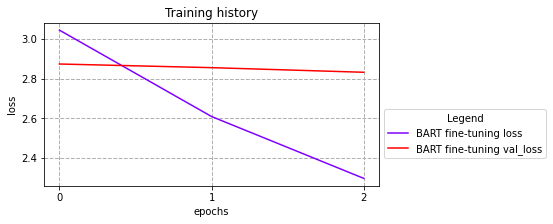

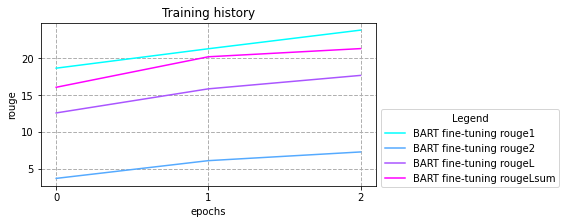

In [13]:
def plot_history(models_history, keys, model_names=[], labels=("epochs", "metrics"), y_scale="linear", figsize=(10,5), cmap='rainbow'):
    """
    Plot the history of the metrics in the history dictionary for each model.
        :param models_history: array of dictionary of the metric history for each model
        :param keys: list of keys of the metrics to plot
        :param model_names: list of names of the models
        :param labels: list of labels of the axes
        :param figsize: size of the figure
        :param cmap: color map used for the plot
    """

    # maps each model to a distinct RGB color
    cmap = plt.cm.get_cmap(cmap, len(keys))

    fig = plt.figure(figsize=figsize)

    # for each model trained
    for i, history in enumerate(models_history):
        # take all pairs of training and val metrics
        for j, metric in enumerate(keys):
            plt.plot(history[metric], label=f"{model_names[i]} {metric}", linestyle="solid", color=cmap(j))
   
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.yscale(y_scale)

    # Adding legend
    plt.legend(
          title ="Legend",
          loc ="best",
          bbox_to_anchor=(1, 0.5))
    plt.title("Training history")
    plt.grid(linestyle='--', linewidth=1)
    plt.show()

model_history = [history]
model_names = ["BART fine-tuning"]
plot_history(model_history, keys=['loss', 'val_loss'], model_names=model_names, labels=("epochs", "loss"), figsize=(6,3))
plot_history(model_history, keys=['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], model_names=model_names, labels=("epochs", "rouge"), figsize=(6,3), cmap="cool")

## 3. Evaluation

### 3.1 Reading the test set
In the evaluation stage, the test set consists of 1,027 episodes. It is provided in the [Spotify Podcast Dataset](https://podcastsdataset.byspotify.com/) separately from the training set, so we can use it to evaluate our model.

In [45]:
metadata_path_test = os.path.join(dataset_path, "spotify-podcasts-2020", "metadata-summarization-testset.tsv")
metadata_test = pd.read_csv(metadata_path_test, sep='\t')
print("Columns: ", metadata_test.columns)
print("Shape: ", metadata_test.shape)

Columns:  Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix'],
      dtype='object')
Shape:  (1027, 12)


In [46]:
# drop NaN values or empty descriptions if any
metadata_test.dropna(subset=['episode_description', 'show_description'], inplace=True)
metadata_test = metadata_test[[len(desc.strip()) > 0 for desc in metadata_test['episode_description']]]
print("Test set size after dropping NaN values: \n", metadata_test.shape)

Test set size after dropping NaN values: 
 (1025, 12)


In [4]:
# load the tokenizer from the hub
model_finetuned_checkpoint = "gmurro/bart-large-finetuned-filtered-spotify-podcast-summ"
tokenizer = AutoTokenizer.from_pretrained(model_finetuned_checkpoint)

### 3.2 Transcript filtering for the test set
For each episode in then test set, extract the chunks from the transcript, classify them to evaluate their salience and take the ones with the highest score up to fulfill 1024 tokens. This step is necessary due to the limited length of the input sequence in BART.

In [ ]:
chunk_classifier = keras.models.load_model("modelChunkNN")
sentence_encoder = SentenceTransformer('all-MiniLM-L6-v2')

metadata_test['filtered_transcript'] = metadata_test.progress_apply(lambda x: transcript_filtering(x, chunk_classifier, sentence_encoder, tokenizer, test_set=True), axis=1)

metadata_test[['episode_uri','filtered_transcript', 'episode_description']].to_csv(os.path.join(dataset_path, "filtered_testset.csv"), index=False)
print("Filtering done!")

### 3.3 Evaluating the model
We use the filtered transcripts as input for the evaluation. Our fine-tuned model is evaluated using the ROUGE metric and the BERTScore metric.
We use the results to compare our model to the pretrained version of bart `bart-large-cnn` to quantify how well our model performs with respect to the baseline.

In [3]:
# load the filtered test set
test_set = load_dataset('csv', data_files=os.path.join(dataset_path, "filtered_testset.csv"))['train']
print(f"Test set size: {test_set.num_rows}")

Using custom data configuration default-bae9440a6612428a
Reusing dataset csv (C:\Users\peppe\.cache\huggingface\datasets\csv\default-bae9440a6612428a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 1/1 [00:00<00:00, 142.74it/s]

Test set size: 1025


In [6]:
def dataset_to_tf(dataset, tokenizer, model, max_input_length = 1024, max_target_length = 256, eval_batch_size = 2):
    """
    Convert a dataset to a tensorflow dataset.

    Parameters
    ----------
    dataset : Dataset
        The dataset to convert.
    tokenizer : AutoTokenizer
        The tokenizer to use.
    model : TFAutoModelForSeq2SeqLM
        The model to use.
    max_input_length : int
        The maximum length of the input sequences. Default: 1024.
    max_target_length : int
        The maximum length of the target sequences. Default: 256.
    eval_batch_size : int
        The batch size used for evaluation. Default: 2.
    """

    # tokenize the set
    set_tokenized = dataset.map(
        lambda batch: batch_tokenize_preprocess(
            batch, "filtered_transcript", "episode_description", tokenizer, max_input_length, max_target_length
        ),
        batched=True,
        remove_columns=dataset.column_names,
        desc="Running tokenizer on the given dataset"
    )

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

    dataset_tf  = set_tokenized.to_tf_dataset(
        batch_size=eval_batch_size,
        columns=["input_ids", "attention_mask", "labels"],
        shuffle=False,
        collate_fn=data_collator,
    )
    return dataset_tf


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

def predict(test_dataset, model, tokenizer, gen_kwargs, eval_batch_size):
    """
    Generate predictions for the test set
    
    Parameters
    ----------
    test_dataset : datasets.Dataset
        Test set
    model : tf.keras.Model
        Model to use for generation
    tokenizer : transformers.AutoTokenizer
        Tokenizer to use for generation
    gen_kwargs : dict
        Keyword arguments for the generation
    eval_batch_size : int
        Batch size for evaluation
    
    Returns
    -------
    Pair correspoding to the list of predictions and the list of labels
    """
    predictions = []
    references  = []

    # convert the dataset to a tensorflow dataset prebatched
    testset_tf = dataset_to_tf(test_dataset, tokenizer, model, max_input_length = 1024, max_target_length = 256, eval_batch_size = eval_batch_size)

    # generate the predicted summaries
    for batch in tqdm(testset_tf, desc="Generating summaries", total=len(test_dataset)//eval_batch_size):
        labels = batch.pop("labels")
        batch.update(gen_kwargs)
        generated_tokens = model.generate(**batch)
        if isinstance(generated_tokens, tuple):
            generated_tokens = generated_tokens[0]
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

        predictions.extend(decoded_preds)
        references.extend(decoded_labels)
    return predictions, references

The hyperparameters used by BART during the generation are the same defined by Song et al. (2020) in their [paper](https://arxiv.org/abs/2011.04132) submitted on TREC 2020.

In [47]:
model_checkpoint_finetuned = "gmurro/bart-large-finetuned-filtered-spotify-podcast-summ" 
tokenizer_finetuned = AutoTokenizer.from_pretrained(model_checkpoint_finetuned)
model_finetuned = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint_finetuned)

model_checkpoint_pretrained = "facebook/bart-large-cnn"
tokenizer_pretrained = AutoTokenizer.from_pretrained(model_checkpoint_pretrained)
model_pretrained = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint_pretrained)

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at gmurro/bart-large-finetuned-filtered-spotify-podcast-summ.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.
All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large-cnn.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [9]:
# bart generation parameters
gen_kwargs = {
    "length_penalty": 2.0,
    "num_beams": 4,
    "no_repeat_ngram_size": 3,
    "min_length": 39,
    "max_length": 250
    }

# predict on the test set with the finetuned model
predictions_ft, references_ft = predict(test_set, model_finetuned, tokenizer_finetuned, gen_kwargs, eval_batch_size=2)  

# predict on the test set with the pretrained model
predictions_pt, references_pt = predict(test_set, model_pretrained, tokenizer_pretrained, gen_kwargs, eval_batch_size=1)
print("Predictions done!")

Generating summaries: 100%|██████████| 513/513 [13:24:11<00:00, 94.30s/it]
Predictions done!


Visualize predictions using both models.

In [10]:
references_ft[10].replace("\n", " ")

'This episode is full, and we mean FULL, of behavioral principles. Dr. Steve Kurtz reached out to us after hearing guest Chelsea (Outloud Podcast) talk about Selective Mutism. Steve in an internationally recognized expert #BFD in child psychology. He is also the founder of the Selective Mutism Programs at both the NYU Child Study Center and the Child Mind Institute. In his email to us he said let’s talk about “awesome ABA implemented in a non-autistic context.” It was almost like he knew what we did over here at BBP. Steve instantly became one of our favorite guests and an honorary Behavior B. Steve also sent us both pins that say, “Get Comfortable, Being Uncomfortable.” I mean this guy is the real deal. You are going to love this conversation as much as we did, promise. Love you. Mean it. Show Notes:   Selectivemutismlearning.org   https://www.kurtzpsychology.com/'

In [17]:
num_to_visualize = 3

for _ in range(num_to_visualize):
    i = np.random.randint(0, len(references_ft))

    ref = references_ft[i].replace('\n', ' ')
    ft = predictions_ft[i].replace('\n', ' ')
    pt = predictions_pt[i].replace('\n', ' ')
    print(f"Creator-provided description: \n\t{ref}")
    print(f"Fine-tuned model prediction: \n\t{ft}")
    print(f"Pre-trained model prediction: \n\t{pt}")
    print("\n")

Creator-provided description: 
	Mallory Rubin addresses the handwritten expression of gratitude.
Fine-tuned model prediction: 
	Amanda and Emily discuss the joy of a handwritten thank you note. They also discuss the social contract that keeps us in a cycle of obligation and obligation and how to break out of it.
Pre-trained model prediction: 
	Amanda Fosters says handwritten thank-you notes perpetuate a cycle of obligation. She says there are a lot of other ways to show gratitude. "There's nothing more exciting and this day and age than getting an unsolicited nice thing in the mail"


Creator-provided description: 
	Health Mantra   ---   This episode is sponsored by  · Anchor: The easiest way to make a podcast. https://anchor.fm/app  Support this podcast: https://anchor.fm/RaniaJaziri/support
Fine-tuned model prediction: 
	Everyday is a new day full of hope, happiness and health. I m getting healthier and healthier and feeling better and better. I always feel good and as a result my bo

In [3]:
# read predictions and references (if stored)
df_pred = pd.read_csv(os.path.join(dataset_path, "predictions_ft.csv"))
predictions_ft = df_pred['predictions'].tolist()
references_ft = df_pred['references'].tolist()

df_pred = pd.read_csv(os.path.join(dataset_path, "predictions_pt.csv"))
predictions_pt = df_pred['predictions'].tolist()
references_pt = df_pred['references'].tolist()

Evaluation using ROUGE and BERTScore as metrics.

In [25]:
def rouge_evaluation(predictions, references):
    """
    Evaluate the ROUGE score for the given predictions and references
    
    Parameters
    ----------
    predictions : list
        List of predictions
    references : list
        List of references
    
    Returns
    -------
    dict
        ROUGE score
    """
    rouge = evaluate.load('rouge')
    results_rouge = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

    df_rouge = pd.DataFrame({'precision': [round(value.mid.precision,4) for key, value in results_rouge.items()],
                             'recall': [round(value.mid.recall,4) for key, value in results_rouge.items()],  
                             'f1': [round(value.mid.fmeasure,4) for key, value in results_rouge.items()]},
                             index=results_rouge.keys())

    return df_rouge

def bertscore_evaluation(predictions, references, idf_weighting=True):
    """
    Evaluate the BERTScore score for the given predictions and references
    
    Parameters
    ----------
    predictions : list
        List of predictions
    references : list
        List of references
    idf_weighting : bool
        Whether to use idf weighting
    
    Returns
    -------
    dict
        BERTScore score
    """
    precision, recall, fmeasure = bert_score.score(cands=predictions, refs=references, lang="en", model_type="microsoft/deberta-xlarge-mnli", num_layers=40, idf=idf_weighting)
    df_bertscore = pd.DataFrame({'precision': [round(precision.mean().item(), 4), round(precision.std().item(), 4)],
                                 'recall': [round(recall.mean().item(), 4), round(recall.std().item(),4)],
                                 'f1': [round(fmeasure.mean().item(), 4), round(fmeasure.std().item(),4)]},
                             index=["mean", "std"])

    return df_bertscore

#### 3.3.1 Evaluation of the fine-tuned model `bart-large-finetuned-filtered-spotify-podcast-summ`

In [6]:
# compute the ROUGE score on fine-tuned model
rouge_ft = rouge_evaluation(predictions_ft, references_ft)
rouge_ft

,precision,recall,f1
rouge1,0.3250,0.2315,0.2370
rouge2,0.0884,0.0677,0.0670
rougeL,0.2160,0.1634,0.1621
rougeLsum,0.2846,0.2003,0.2058


In [16]:
# compute the BERT score with IDF on fine-tuned model
bertscore_ft = bertscore_evaluation(predictions_ft, references_ft, idf_weighting=True)
bertscore_ft

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,precision,recall,f1
mean,0.8401,0.8093,0.8240
std,0.0335,0.0422,0.0327


In [17]:
# compute the BERT score without IDF on fine-tuned model
bertscore_ft = bertscore_evaluation(predictions_ft, references_ft, idf_weighting=False)
bertscore_ft

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,precision,recall,f1
mean,0.8631,0.8279,0.8447
std,0.0286,0.0411,0.0299


#### 3.3.2 Evaluation of the pretrained model `bart-large-cnn`

In [7]:
# compute the ROUGE score
rouge_pt = rouge_evaluation(predictions_pt, references_pt)
rouge_pt

,precision,recall,f1
rouge1,0.2357,0.2125,0.1917
rouge2,0.0449,0.0447,0.0379
rougeL,0.1467,0.1408,0.1223
rougeLsum,0.2088,0.1855,0.1684


In [18]:
# compute the BERT score with IDF on pre-trained model
bertscore_pt = bertscore_evaluation(predictions_pt, references_pt, idf_weighting=True)
bertscore_pt

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,precision,recall,f1
mean,0.8103,0.7941,0.8018
std,0.0247,0.0388,0.0277


In [19]:
# compute the BERT score without IDF on pre-trained model
bertscore_pt = bertscore_evaluation(predictions_pt, references_pt, idf_weighting=False)
bertscore_pt

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,precision,recall,f1
mean,0.8317,0.8121,0.8214
std,0.0232,0.0373,0.0262
